In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import gaussian_filter

In [68]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head(10)

Loaded 107738 rows and 15 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_69596/3970016744.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId,eventId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],1_0,1_0_0
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",1_0,1_0_1
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],1_1,1_1_0
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],1_1,1_1_1
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],1_1,1_1_2
5,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,FF,149,-18.29,-79.24,[],1_1,1_1_3
6,PITCH,False,True,False,徐若熙,蔣少宏,林立,S,FF,150,16.25,-56.89,"[{'type': 'PA', 'runnerName': '林立', 'isOut': T...",1_1,1_1_4
7,PITCH,False,True,False,徐若熙,蔣少宏,梁家榮,S,CU,121,-12.19,-26.41,[],1_2,1_2_0
8,PITCH,False,True,False,徐若熙,蔣少宏,梁家榮,F,CU,124,-60.95,-58.92,[],1_2,1_2_1
9,PITCH,False,False,True,徐若熙,蔣少宏,梁家榮,B,CH,132,95.49,207.24,[],1_2,1_2_2


In [69]:
# read a CSV into a dataframe (adjust filename as needed)
pa_filename = './data/pa.csv'  # or provide a full path

if not os.path.exists(pa_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{pa_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")



pas = pd.read_csv(pa_filename, usecols=['batterName', 'pitcherName','result', 'hardness', 'PAId'])
print(f"Loaded {len(pas)} rows and {len(pas.columns)} columns from {pa_filename}")
pas.head()


Loaded 27600 rows and 5 columns from ./data/pa.csv


,batterName,pitcherName,result,hardness,PAId
0,陳晨威,徐若熙,GO,M,1_0
1,林立,徐若熙,SO,NaN,1_1
2,梁家榮,徐若熙,2B,H,1_2
3,廖健富,徐若熙,1B,H,1_3
4,朱育賢,徐若熙,FO,M,1_4


In [70]:
events['coordX'] = events['coordX'] * 0.5 * 0.3937  # convert cm to inches and scale X
events['coordY'] = events['coordY'] * 0.5 * 0.3937  # convert cm to inches and scale Y

In [71]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

In [72]:
bins = 10
x_bin = np.linspace(-40, 40, bins+1, endpoint=True)
y_bin = np.linspace(-45, 45, bins+1, endpoint=True)
x_centers = 0.5 * (x_bin[:-1] + x_bin[1:])
y_centers = 0.5 * (y_bin[:-1] + y_bin[1:])

In [73]:
# define result groups (keep consistent with earlier cells)
hits = {'1B', '2B', '3B', 'HR', 'IHR', 'H'}
bbs = {'uBB', 'IBB'}
hbps = {'HBP'}
non_ab_results = {'SH', 'SF', 'uBB', 'IBB', 'HBP', 'IH', 'IR', 'ID'}
tb_map = {'1B': 1, 'H': 1, '2B': 2, '3B': 3, 'HR': 4, 'IHR': 4}
_swing_tokens = {'SW', 'F', 'FT', 'FOUL_BUNT', 'TRY_BUNT', 'BUNT', 'H'}
_fastball_tokens = {'FF', 'SI', 'FC'} # four-seam, sinker, cutter
_offspeed_tokens = {'CH', 'FO', 'FS', 'KN', 'EP'} # changeup, forkball, split-finger, knuckleball
_breaking_tokens = {'CU', 'SL'} # curveball, slider

In [74]:
def get_result_events(PAId):
    pa = pas[pas['PAId']==PAId]
    result = pa['result'].values[0]
    hardness = pa['hardness'].values[0]
    return result, hardness

def assign_counts_to_pitches(df):
    # iterate rows in order and track balls/strikes for the current plate appearance
    balls = 0
    strikes = 0
    records = []

    for idx, row in df.sort_index().iterrows():
        if row.get('type') != 'PITCH':
            # ignore non-pitch rows for assignment, but if they indicate PA boundary we could reset;
            # we keep simple behavior (resets will happen on inPlay/PA markers below)
            continue
        
        pa_ending_goodness = 100
        # record count before this pitch
        balls_before, strikes_before = balls, strikes
        # update counts based on pitch outcome flags (simple, robust heuristics)
        is_ball = bool(row.get('isBall', False))
        is_strike = bool(row.get('isStrike', False))
        in_play = bool(row.get('inPlay', False))
        pitchCode = row.get('pitchCode', '')
        
        # A foul with 2 strikes does not increase the strike count.
        is_foul_with_two_strikes = pitchCode in ('F', 'FT', 'FOUL_BUNT') and strikes == 2

        # ball increments balls
        if is_ball and not is_strike:
            balls += 1
            pa_ending_goodness = 100
        # strike increments strikes
        elif is_strike and not is_ball and not is_foul_with_two_strikes:
            # only increment on non-inplay strikes; fouls often set isStrike True but rules cap at 2
            if not in_play and strikes < 3:
                strikes += 1
                pa_ending_goodness = 100

        # if the pitch resulted in the ball being put in play or runners indicate a PA event, end the plate appearance
        runners = row.get('runners', [])
        pa_marker = False
        if isinstance(runners, list):
            for r in runners:
                if isinstance(r, dict) and r.get('type') == 'PA':   
                    pa_marker = True
                    break
        
        if in_play or pa_marker or balls >= 4 or strikes >= 3:
            paid = str(row.get('PAId', ''))   
            result, hardness = get_result_events(paid)
            
            if in_play or pa_marker:
                if hardness == 'S': # soft contact
                    pa_ending_goodness = 500
                elif hardness == 'M': # middle contact
                    if result in hits: # hit
                        pa_ending_goodness = False
                    else:
                        pa_ending_goodness = 500
                else:
                    pa_ending_goodness = False
            elif strikes >= 3: 
                if result == 'SO': # strikeout
                    pa_ending_goodness = True
                else: # Could be a dropped third strike, but we'll simplify
                    pa_ending_goodness = True 
            else: # walk or hit by pitch
                pa_ending_goodness = False
                
            balls = 0
            strikes = 0
            in_play = False
            pa_marker = False

        """
        pa_ending_goodness:
        True = strikeout
        False = good contact / walk / hit by pitch
        500 = soft contact
        100 = neither (count progression only)
        """
        
        records.append((idx, balls_before, strikes_before, pa_ending_goodness))

    # build a small DataFrame keyed by original index
    counts_df = pd.DataFrame(records, columns=['index', 'balls', 'strikes', 'pa_ending_goodness']).set_index('index')
    return counts_df

In [75]:
# assign counts to all pitch rows
counts_df = assign_counts_to_pitches(events)

In [76]:
### filter out non-PITCH type
pitcher = events[((events['pitcherName'] == '古林睿煬')) & (events['type'] == 'PITCH')]
# pitcher = events[((events['pitcherName'].isin(events['pitcherName'].unique()))) & (events['type'] == 'PITCH')]
batter = events[((events['batterName'].isin(events['batterName'].unique()))) & (events['type'] == 'PITCH')]
# batter = pitcher.copy()


In [77]:
# merge counts into the pitches DataFrame we want to plot (test_events is already filtered to the pitcher/type)
# ensure indices align (counts_df contains only indices for PITCH rows)
pitcher = pitcher.join(counts_df, how='left')  # balls/strikes will be NaN if reconstruction failed for some rows
batter = batter.join(counts_df, how='left')


# fill missing with 0-0 to avoid issues (or drop NaNs if preferred)
pitcher['balls'] = pitcher['balls'].fillna(0).astype(int)
pitcher['strikes'] = pitcher['strikes'].fillna(0).astype(int)
batter['balls'] = batter['balls'].fillna(0).astype(int)
batter['strikes'] = batter['strikes'].fillna(0).astype(int)

In [78]:
so_events = pitcher[pitcher['pa_ending_goodness'] == True]
so_events.head(50)

,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId,eventId,balls,strikes,pa_ending_goodness
7342,PITCH,False,True,False,古林睿煬,陳重羽,陳俊秀,SW,FO,NaN,-16.171228,-26.470419,"[{'type': 'PA', 'runnerName': '陳俊秀', 'isOut': ...",121_3,121_3_4,2,2,True
7347,PITCH,False,True,False,古林睿煬,陳重羽,曾頌恩,SW,FO,135,0.478346,9.080691,"[{'type': 'PA', 'runnerName': '曾頌恩', 'isOut': ...",121_5,121_5_2,0,2,True
7351,PITCH,False,True,False,古林睿煬,陳重羽,王政順,SW,FF,153,-8.521636,18.080672,"[{'type': 'PA', 'runnerName': '王政順', 'isOut': ...",121_6,121_6_3,1,2,True
7385,PITCH,False,True,False,古林睿煬,陳重羽,陳子豪,SW,FF,154,-4.021645,16.730282,"[{'type': 'PA', 'runnerName': '陳子豪', 'isOut': ...",121_13,121_13_2,0,2,True
7393,PITCH,False,True,False,古林睿煬,陳重羽,王政順,SW,FF,150,-6.271641,9.980295,"[{'type': 'PA', 'runnerName': '王政順', 'isOut': ...",121_15,121_15_3,1,2,True
7402,PITCH,False,True,False,古林睿煬,陳重羽,岳東華,S,CU,122,1.377950,2.779522,[],121_19,121_19_1,1,2,True
11455,PITCH,False,True,False,古林睿煬,陳重羽,王勝偉,SW,FO,133,-6.436995,-14.395640,"[{'type': 'PA', 'runnerName': '王勝偉', 'isOut': ...",133_43,133_43_3,1,2,True
11466,PITCH,False,True,False,古林睿煬,陳重羽,高國麟,S,FO,135,-9.413367,3.458655,"[{'type': 'PA', 'runnerName': '高國麟', 'isOut': ...",133_46,133_46_5,3,2,True
11480,PITCH,False,True,False,古林睿煬,陳重羽,陳真,SW,FF,146,-15.035403,6.104319,"[{'type': 'PA', 'runnerName': '陳真', 'isOut': T...",133_49,133_49_5,3,2,True
11503,PITCH,False,True,False,古林睿煬,陳重羽,范國宸,SW,FO,136,1.167320,7.757858,"[{'type': 'PA', 'runnerName': '范國宸', 'isOut': ...",133_56,133_56_4,1,2,True


In [79]:
def get_pitchType_events(events_parent, pitch_types='fastball'):
    if pitch_types == 'fastball':
        pitch_types = _fastball_tokens
    elif pitch_types == 'offspeed':
        pitch_types = _offspeed_tokens
    elif pitch_types == 'breaking':
        pitch_types = _breaking_tokens
    return events_parent[events_parent['pitchType'].isin(pitch_types)]

def get_count_events(events_parent, balls, strikes):
    if isinstance(balls, list):
        return events_parent[(events_parent['balls'].isin(balls)) & (events_parent['strikes'] == strikes)]
    elif isinstance(strikes, list):
        return events_parent[(events_parent['balls'] == balls) & (events_parent['strikes'].isin(strikes))]
    elif isinstance(balls, list) and isinstance(strikes, list):
        return events_parent[(events_parent['balls'].isin(balls)) & (events_parent['strikes'].isin(strikes))]
    else:
        return events_parent[(events_parent['balls'] == balls) & (events_parent['strikes'] == strikes)]

def get_pitchCode_events(events_parent, pitch_code='S'):
    if isinstance(pitch_code, list):
        return events_parent[events_parent['pitchCode'].isin(pitch_code)]
    else:
        return events_parent[events_parent['pitchCode']==pitch_code]

def get_swing_events(events_parent):
    noswing_events = events_parent[events_parent['pitchCode'].isin(['S', 'B'])]
    swing_events = events_parent[events_parent['pitchCode'].isin(_swing_tokens)]
    in_swing = events_parent['pitchCode'].isin(_swing_tokens)
    in_sw = events_parent['pitchCode']=='SW'
    in_contact = events_parent['pitchCode']!='SW'
    whiff_events = events_parent[in_swing & in_sw]
    contact_events = events_parent[in_swing & in_contact]
    return noswing_events, swing_events, whiff_events, contact_events

def get_SO_events(events_parent):
    return events_parent[events_parent['pa_ending_goodness']==True]

def get_soft_events(events_parent):
    return events_parent[events_parent['pa_ending_goodness']==500]

def get_good_events(events_parent):
    good_crit = (events_parent['pa_ending_goodness']==True) | (events_parent['pa_ending_goodness']==500)
    return events_parent[good_crit], events_parent[~good_crit]


def smooth_map(data_map, ball_diameter=2.9):
    """
    Smooths a 2D map using a Gaussian filter with sigma related to the ball size.
    The filter spreads the count in each bin to its neighbors.

    Args:
        data_map (np.ndarray): The 2D count map to smooth.
        ball_diameter (float): The diameter of the baseball in inches.

    Returns:
        np.ndarray: The smoothed map.
    """
    # Calculate bin widths in inches from global bin definitions
    x_bin_width = x_bin[1] - x_bin[0]
    y_bin_width = y_bin[1] - y_bin[0]

    # Use ball radius for the standard deviation of the Gaussian kernel
    sigma_inches = ball_diameter / 2.0
    
    # Convert sigma from inches to bin units for each axis
    sigma_y = sigma_inches / y_bin_width
    sigma_x = sigma_inches / x_bin_width

    # Apply the Gaussian filter to the map
    # The input map is converted to float to handle non-integer values after filtering.
    smoothed_map = gaussian_filter(data_map.astype(float), sigma=(sigma_y, sigma_x))
    
    return smoothed_map

# Update the event_to_map function to optionally apply smoothing
def event_to_map(events_parent, smooth=True):
    """
    Generates a 2D count map from pitch events.

    Args:
        events_parent (pd.DataFrame): DataFrame containing pitch events.
        smooth (bool): If True, applies Gaussian smoothing to the map.

    Returns:
        np.ndarray: A 2D map of pitch counts.
    """
    stats_map = np.zeros((bins, bins))
    for i in range(bins):
        for j in range(bins):
            # Check which events fall into the current bin
            in_x_bin = (events_parent['coordX'] >= x_bin[i]) & (events_parent['coordX'] < x_bin[i+1])
            in_y_bin = (events_parent['coordY'] >= y_bin[j]) & (events_parent['coordY'] < y_bin[j+1])
            # Count the events in the bin
            stats_map[j, i] = np.sum(in_x_bin & in_y_bin)
            
    if smooth:
        # If smoothing is enabled, apply the smooth_map function
        return smooth_map(stats_map)
    
    return stats_map


In [80]:
def single_map(ax, data_map, type='probability', **kargs):

    if type == 'probability':
        ax.imshow(data_map, extent=(-40, 40, -45, 45), origin='lower', cmap='Reds', alpha=0.8, **kargs)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Pitch Location Map ({type})')
    ax.set_xlabel('Horizontal Location (inch)')
    ax.set_ylabel('Vertical Location (inch)')
    for i in range(bins):
        for j in range(bins):
            if type == 'count':
                ax.text(x_centers[i], y_centers[j], f"{data_map[j,i]:.0f}",
                        ha='center', va='center', color='black', fontsize=8)
            elif type == 'probability':
                ax.text(x_centers[i], y_centers[j], f"{data_map[j,i]*100:.0f}%",
                        ha='center', va='center', color='black', fontsize=8)
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                        linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))

def plot_map(pitcher_map, batter_map, type='count'):
    
    bins = pitcher_map.shape[0]
    fig, axes = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)

    single_map(axes[0], pitcher_map, type=type)
    single_map(axes[1], batter_map, type=type)

    if type == 'count':
        combine_map = pitcher_map + batter_map
    elif type == 'probability':
        combine_map = pitcher_map * batter_map
    single_map(axes[2], combine_map, type=type)

    plt.show()

In [81]:
def joint_called_strike(pitcher_events, batter_events):
    """
    Compute the joint called strike rate (strike zone) for pitcher and batter events.
    
    size of combine_called_strike_rate = (bins, bins)
    """
    called_strike_matrix_p = event_to_map(get_pitchCode_events(pitcher_events, pitch_code='S'))
    called_ball_matrix_p = event_to_map(get_pitchCode_events(pitcher_events, pitch_code='B'))
    called_strike_matrix_b = event_to_map(get_pitchCode_events(batter_events, pitch_code='S'))
    called_ball_matrix_b = event_to_map(get_pitchCode_events(batter_events, pitch_code='B'))
    called_strike_rate_pitcher = called_strike_matrix_p / (called_strike_matrix_p + called_ball_matrix_p + 1e-6)
    called_strike_rate_batter = called_strike_matrix_b / (called_strike_matrix_b + called_ball_matrix_b + 1e-6)
    combine_called_strike_rate = called_strike_rate_pitcher * called_strike_rate_batter
    return combine_called_strike_rate

def pitch_distribution(pitcher_events):
    """
    Compute the pitch type distribution (fastball, offspeed, breaking) for pitcher events.
    
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    pitch_count = np.sum(event_to_map(pitcher_events))
    
    pitchTypes = ['fastball', 'offspeed', 'breaking']
    events = []
    counts = []
    rates = []
    for i, pitchtype in enumerate(pitchTypes):
        event = get_pitchType_events(pitcher_events, pitch_types=pitchtype)
        map = event_to_map(event)
        rate = map / (pitch_count + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
        
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)

    return events, counts, rates

def swing_distribution(pitchType_events, pitchType_counts):
    """
    Compute the swing distribution for each events.
    
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        _, event, _, _ = get_swing_events(pitchType_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def whiff_distribution(pitchType_swing_events, pitchType_swing_counts):
    """
    Compute the whiff distribution for each swing events.

    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_swing_events)):
        _, _, event, _ = get_swing_events(pitchType_swing_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_swing_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def contact_distribution(pitchType_swing_events, pitchType_swing_counts):
    """
    Compute the contact distribution for each swing events.
    size:
    events: list of 3 elements, each is a DataFrame of events for a pitch type
    counts: (bins, bins, 3) array of counts for each pitch type
    rates: (bins, bins, 3) array of rates for each pitch type
    """
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_swing_events)):
        _, _, _, event = get_swing_events(pitchType_swing_events[i])
        map = event_to_map(event)
        rate = map / (pitchType_swing_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def SO_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        event = get_SO_events(pitchType_events[i])
        map = event_to_map(event)

        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def soft_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        event = get_soft_events(pitchType_events[i])
        map = event_to_map(event)

        rate = map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(event)
        counts.append(map)
        rates.append(rate)
    
    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates

def good_distribution(pitchType_events, pitchType_counts):
    events = []
    counts = []
    rates = []
    for i in range(len(pitchType_events)):
        good_event, bad_event = get_good_events(pitchType_events[i])
        good_map = event_to_map(good_event)
        bad_map = event_to_map(bad_event)

        good_rate = good_map / (pitchType_counts[:, :, i] + 1e-6)
        bad_rate = bad_map / (pitchType_counts[:, :, i] + 1e-6)

        events.append(good_event)
        counts.append(good_map)
        rates.append(good_rate)

    counts = np.stack(counts, axis=-1)
    rates = np.stack(rates, axis=-1)
    return events, counts, rates



def joint_rates(pitcher_events, batter_events):
    
    event_p, pitch_count_p, _ = pitch_distribution(pitcher_events)
    swing_events_p, swing_counts_p, swing_rates_p = swing_distribution(event_p, pitch_count_p) # net swing rate
    whiff_events_p, whiff_counts_p, whiff_rates_p = whiff_distribution(swing_events_p, swing_counts_p) # whiff rate when swing made
    contact_events_p, contact_counts_p, contact_rates_p = contact_distribution(swing_events_p, swing_counts_p) # contact rate when swing made
    soft_events_p, soft_counts_p, soft_rates_p = soft_distribution(contact_events_p, contact_counts_p) # soft contact rate when contact made
    so_events_p, so_counts_p, so_rates_p = SO_distribution(event_p, pitch_count_p) # net strikeout rate
    
    event_b, pitch_count_b, _ = pitch_distribution(batter_events)
    swing_events_b, swing_counts_b, swing_rates_b = swing_distribution(event_b, pitch_count_b) # net swing rate
    whiff_events_b, whiff_counts_b, whiff_rates_b = whiff_distribution(swing_events_b, swing_counts_b) # whiff rate when swing made
    contact_events_b, contact_counts_b, contact_rates_b = contact_distribution(swing_events_b, swing_counts_b) # contact rate when swing made
    soft_events_b, soft_counts_b, soft_rates_b = soft_distribution(contact_events_b, contact_counts_b) # soft contact rate when contact made
    so_events_b, so_counts_b, so_rates_b = SO_distribution(event_b, pitch_count_b) # net strikeout rate

    joint_swing_rate = swing_rates_p * swing_rates_b
    joint_whiff_rate = whiff_rates_p * whiff_rates_b
    joint_contact_rate = contact_rates_p * contact_rates_b
    joint_soft_rate = soft_rates_p * soft_rates_b
    joint_so_rate = so_rates_p * so_rates_b

    return joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_soft_rate, joint_so_rate

def pitcher_vs_batter(pitcher, batter, strike, ball):
    pitcher_events = get_count_events(pitcher, balls=ball, strikes=strike)
    batter_events  = get_count_events(batter,  balls=ball, strikes=strike)

    joint_called_strike_rate = joint_called_strike(pitcher_events, batter_events)
    joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_soft_rate, joint_so_rate = joint_rates(pitcher_events, batter_events)

    # # Pitches distributions
    _, pitchType_count_p, pitchType_prob_p = pitch_distribution(pitcher_events)

    return joint_called_strike_rate, joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_soft_rate, joint_so_rate, pitchType_prob_p, pitchType_count_p


In [89]:
strike = 2
ball = [0, 1, 2, 3]
joint_called_strike_rate, joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_soft_rate, joint_so_rate, pitchType_prob_p, pitchType_count_p = pitcher_vs_batter(pitcher, batter, strike, ball)

Pitch Type Probability Map (Pitcher)


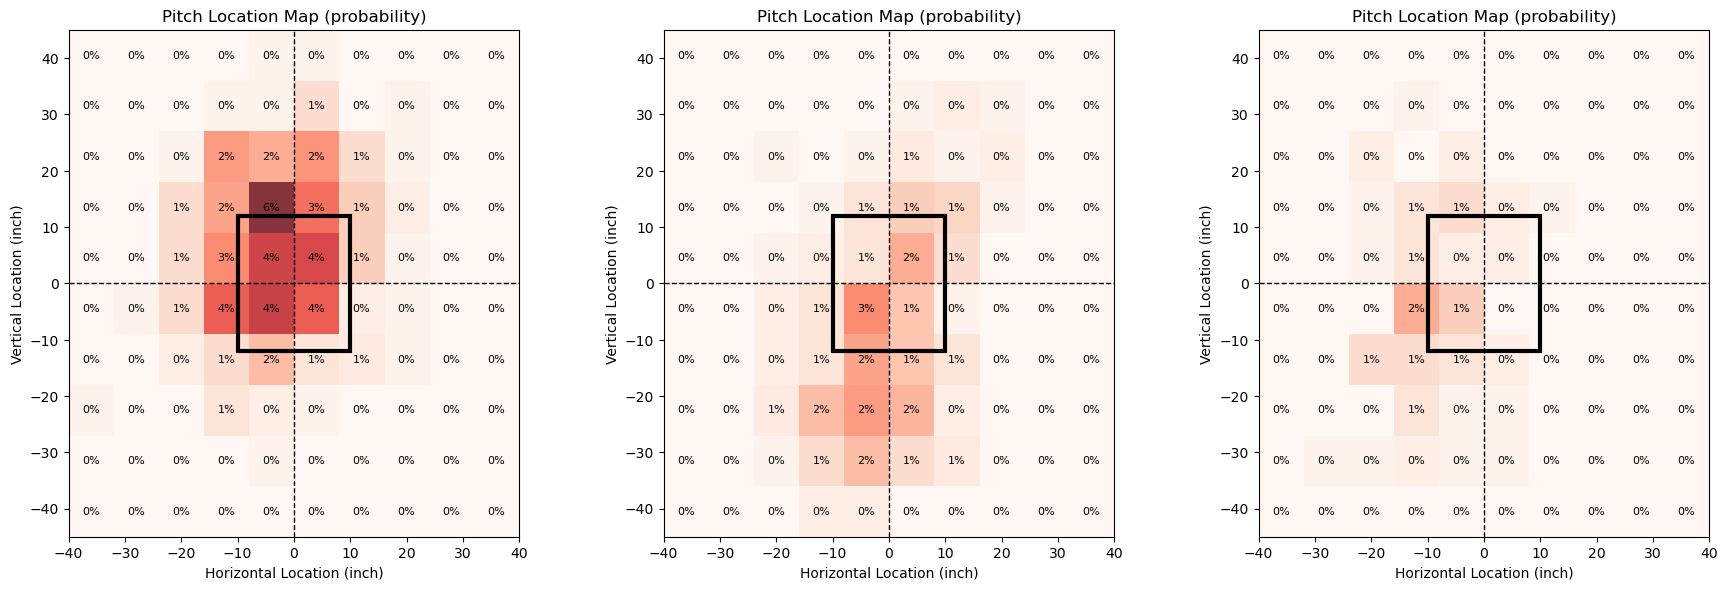

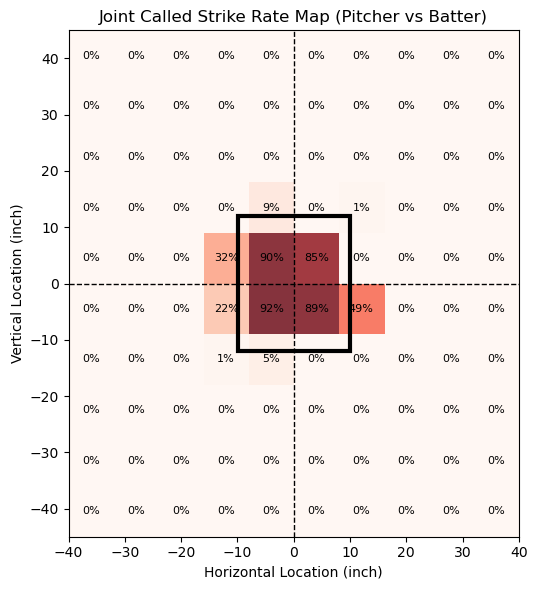

Joint Swing Rate Map (Pitcher vs Batter)


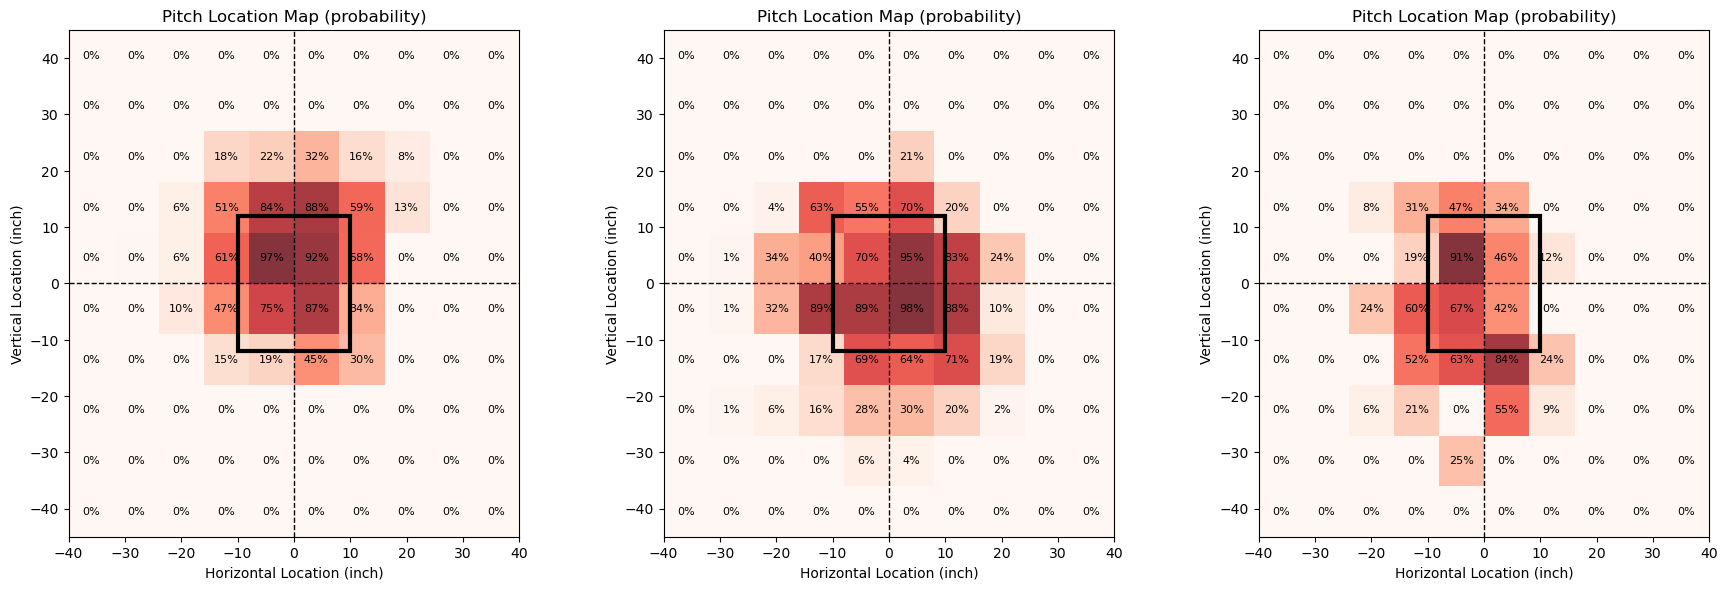

Joint Whiff Rate Map (Pitcher vs Batter)


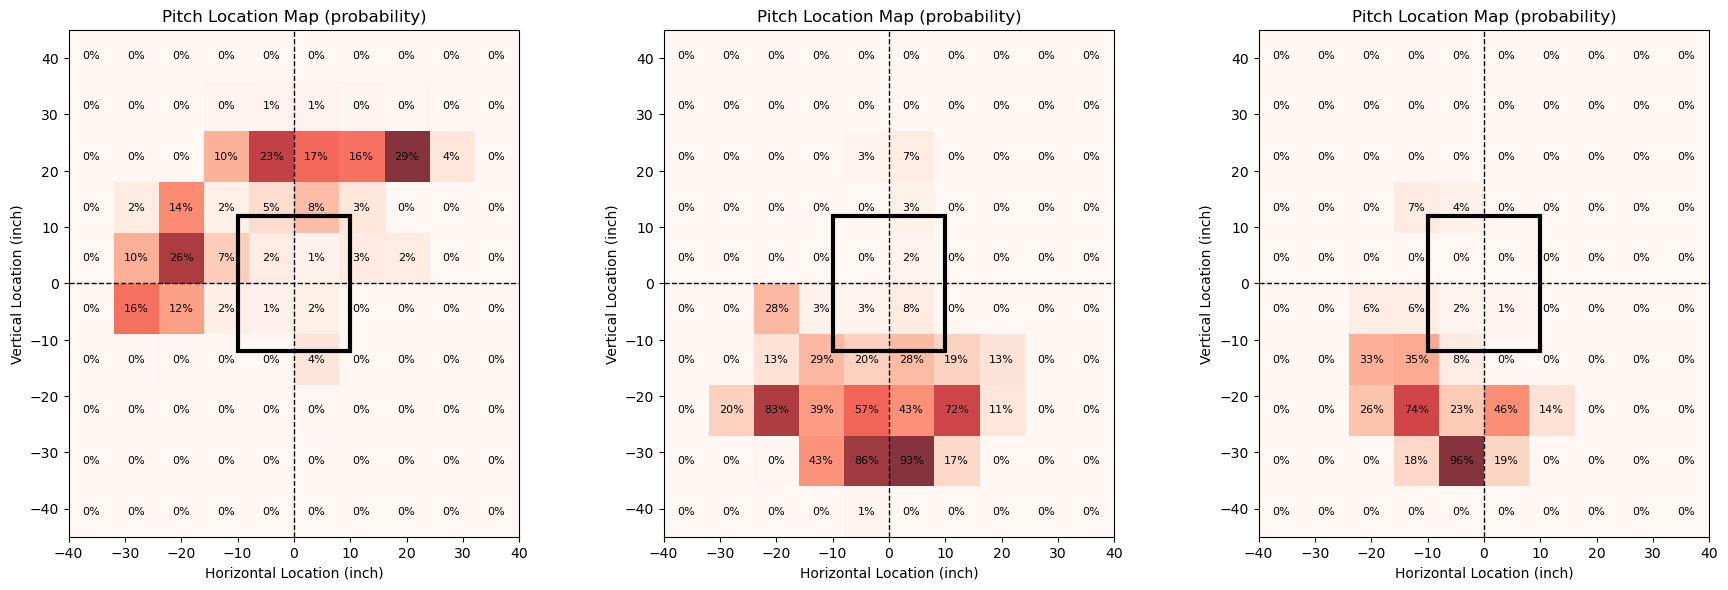

Joint Contact Rate Map (Pitcher vs Batter)


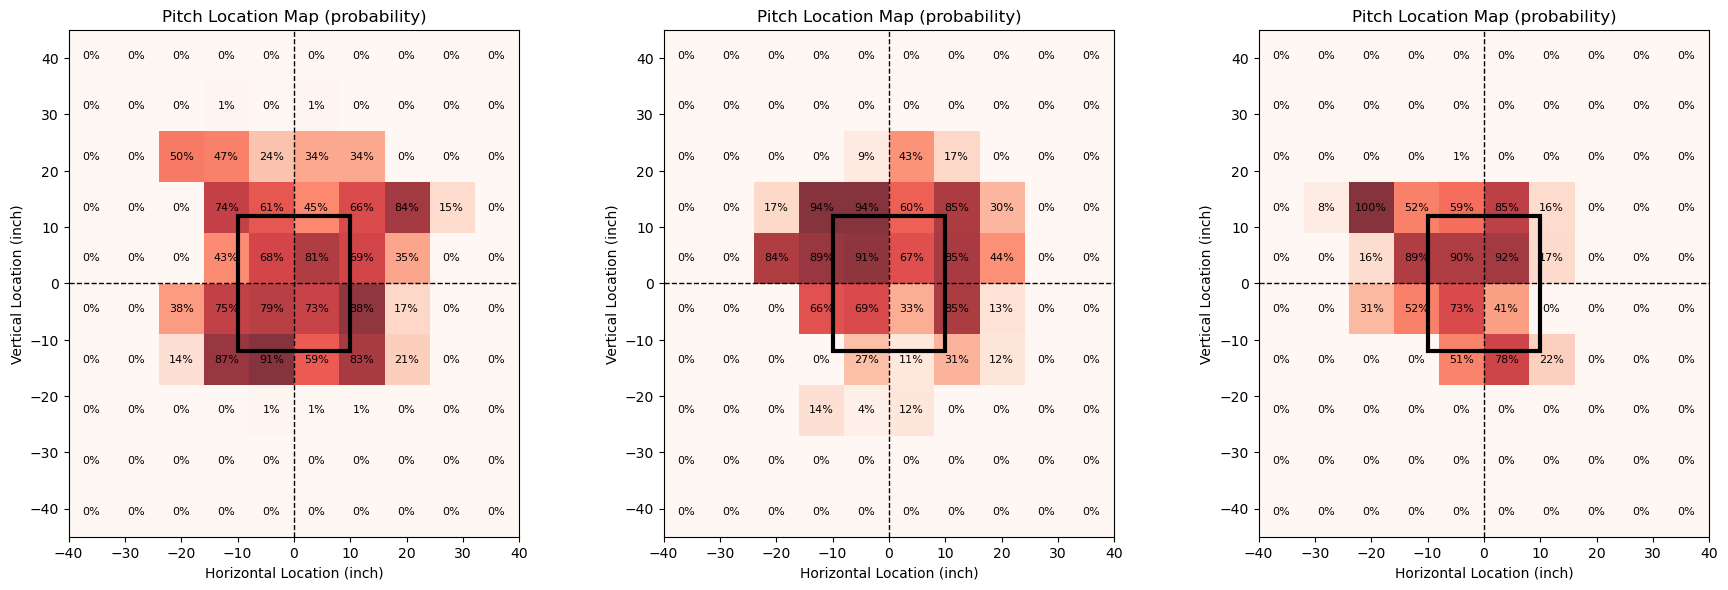

Joint Soft Contact Rate (Pitcher vs Batter)


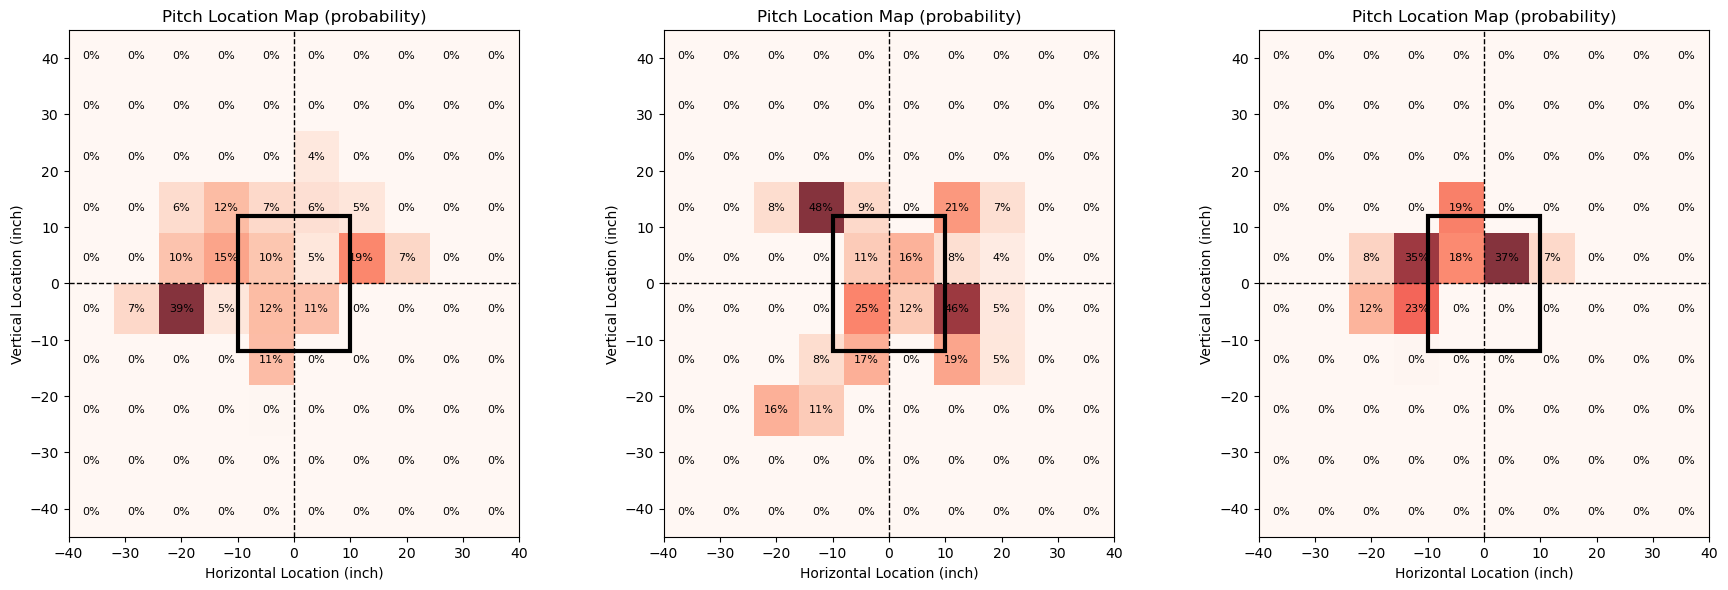

Joint SO Rate Map (Pitcher vs Batter)


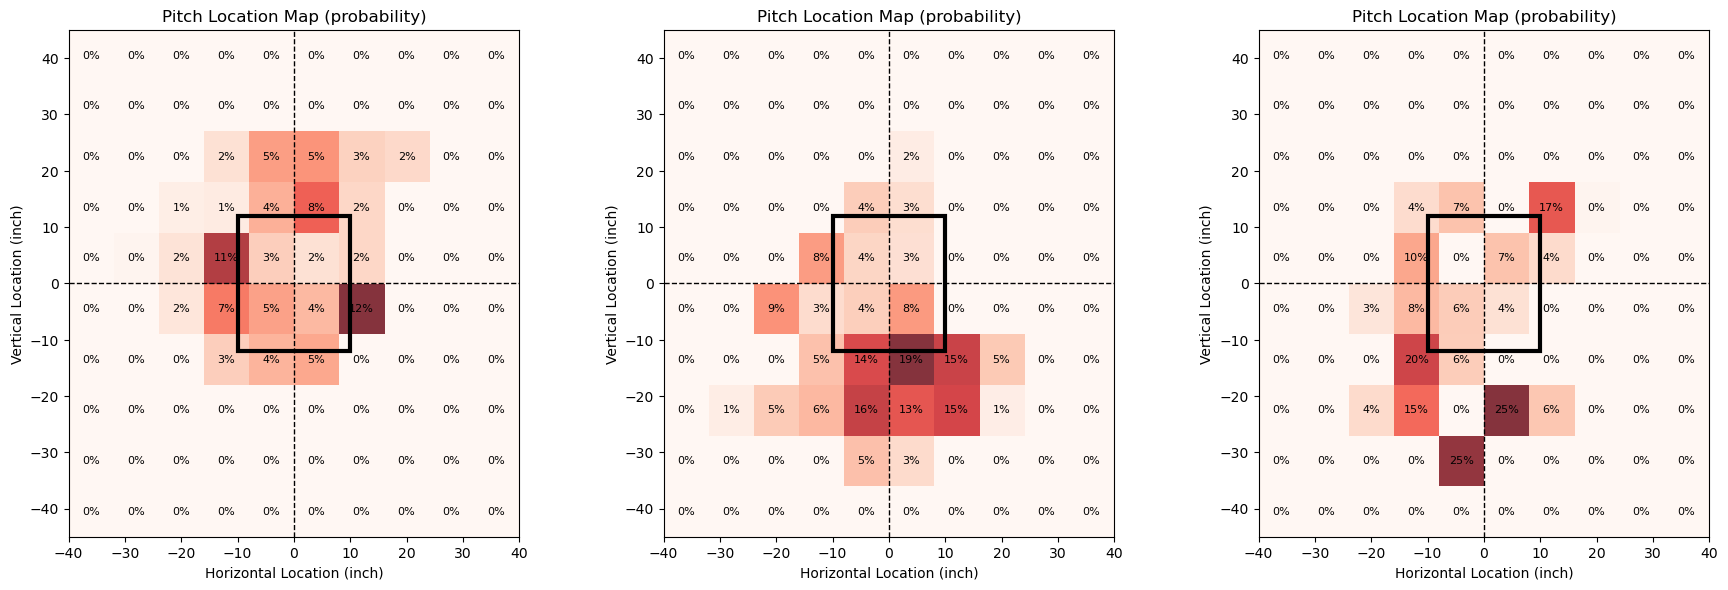

In [96]:
print("Pitch Type Probability Map (Pitcher)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], pitchType_prob_p[:, :, i], type='probability', vmin=0, vmax=np.max(pitchType_prob_p))
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6,6), tight_layout=True)
single_map(ax, joint_called_strike_rate, type='probability')
plt.title('Joint Called Strike Rate Map (Pitcher vs Batter)')
plt.show()

print("Joint Swing Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], joint_swing_rate[:, :, i], type='probability')
plt.show()

print("Joint Whiff Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], joint_whiff_rate[:, :, i], type='probability')
plt.show()


print("Joint Contact Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], joint_contact_rate[:, :, i], type='probability')
plt.show()

print("Joint Soft Contact Rate (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], joint_soft_rate[:, :, i], type='probability')
plt.show()

print("Joint SO Rate Map (Pitcher vs Batter)")
fig, ax = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
for i in range(3):
    single_map(ax[i], joint_so_rate[:, :, i], type='probability')
plt.show()



In [97]:
# fastball_rate, offspeed_rate, breaking_rate = pitchType_prob_p[:, :, 0], pitchType_prob_p[:, :, 1], pitchType_prob_p[:, :, 2]

# print("Pitcher 0-0 pitch type rates:")
# fig, axes = plt.subplots(1, 3, figsize=(18,6), tight_layout=True)
# single_map(axes[0], fastball_rate, vmin=0, vmax=np.max(pitchType_prob_p))
# single_map(axes[1], offspeed_rate, vmin=0, vmax=np.max(pitchType_prob_p))
# single_map(axes[2], breaking_rate, vmin=0, vmax=np.max(pitchType_prob_p))
# plt.show()
# ###################################################################################################################

In [98]:
# Sample a pitch location (x, y) and pitch type from the 3D probability matrix pitchType_prob_p.
# The matrix shape is (bins_y, bins_x, 3) for ['fastball', 'offspeed', 'breaking'].

def sample_pitch(prob_matrix,
                 n=1,
                 pitch_labels=('fastball', 'offspeed', 'breaking'),
                 continuous=False,
                 seed=None):
    """
    Draw n samples from the joint distribution over (y_bin, x_bin, pitch_type).

    - prob_matrix: ndarray of shape (bins_y, bins_x, n_types), e.g., pitchType_prob_p
    - continuous: if True, sample uniformly within the chosen bin; else use bin centers
    - seed: optional RNG seed for reproducibility
    """
    p = np.nan_to_num(prob_matrix, nan=0.0).astype(float).copy()
    p[p < 0] = 0.0
    total = p.sum()
    if total <= 0:
        raise ValueError("Probability matrix sums to 0. Nothing to sample from.")
    p /= total

    rng = np.random.default_rng(seed)
    flat_idx = rng.choice(p.size, size=n, p=p.ravel(), replace=True)
    js, is_, ks = np.unravel_index(flat_idx, p.shape)  # axis0=y, axis1=x, axis2=type

    samples = []
    for j, i, k in zip(js, is_, ks):
        if continuous:
            x = rng.uniform(x_bin[i], x_bin[i + 1])
            y = rng.uniform(y_bin[j], y_bin[j + 1])
        else:
            x = float(x_centers[i])
            y = float(y_centers[j])

        samples.append({
            'pitch_type_index': int(k),
            'pitch_type': pitch_labels[k] if k < len(pitch_labels) else f'type_{k}',
            'x_bin': int(i),
            'y_bin': int(j),
            'x': float(x),
            'y': float(y),
            'cell_prob': float(p[j, i, k])
        })

    return samples[0] if n == 1 else samples

In [ ]:
# def one_progression(strike, ball):
#     joint_called_strike_rate, joint_swing_rate, joint_whiff_rate, joint_contact_rate, joint_soft_rate, joint_so_rate, pitchType_prob_p, pitchType_count_p = pitcher_vs_batter(pitcher, batter, strike, ball)
#     joint_called_strike_rate = np.tile(joint_called_strike_rate[:, :, np.newaxis], (1, 1, 3))
    
    
#     # when pitch is thrown
#     swing_prob = joint_swing_rate # probability of swing
#     strike_prob = (1-swing_prob) * joint_called_strike_rate # probability of called strike if no swing
#     ball_prob = (1-swing_prob) * (1-joint_called_strike_rate) # probability of called ball if no swing

#     # if swing
#     whiff_prob = joint_whiff_rate # when swing, probability of whiff
#     strike_prob += swing_prob * whiff_prob # probability of strike if swing (swing and miss)
    
#     # if contact
#     contact_prob = joint_contact_rate # probability of contact
#     good_prob = contact_prob * joint_goodness_rate[0] # when contact, probability of good contact
#     bad_prob = contact_prob * joint_goodness_rate[1] # when contact, probability of bad contact
#     normal_prob = contact_prob * joint_goodness_rate[2] # when contact, probability of normal contact
    
#     return strike_prob, ball_prob, (good_prob, bad_prob, normal_prob), pitchType_prob_p

In [100]:
# strike_prob, ball_prob, (good_prob, bad_prob, normal_prob), pitchType_prob_p = one_progression(
#     strike=2,
#     ball=[0, 1, 2, 3]
# )

# sampled_pitches = sample_pitch(pitchType_prob_p, n=100, continuous=True, seed=None)
# fig, axes = plt.subplots(3, 6, figsize=(36,18), tight_layout=True)

# for sp in sampled_pitches:
#     # print(sp)
#     if sp['pitch_type'] == 'fastball':
#         color = 'b'
#         ax = axes[0, :]
#     elif sp['pitch_type'] == 'offspeed':
#         color = 'r'
#         ax = axes[1, :]
#     else:
#         color = 'orange'
#         ax = axes[2, :]
#     for a in ax:
#         a.scatter(sp['x'], sp['y'], color=color, s=100, alpha=0.7)

# # x_, y_, pitch_type_index = sampled_pitches['x'], sampled_pitches['y'], sampled_pitches['pitch_type_index']


# # print(f"At count 0-0, for sampled pitch at ({sampled_pitches['x']:.2f}, {sampled_pitches['y']:.2f}) of type {sampled_pitches['pitch_type']}:")

# # print(f"  Ball Probability: {ball_prob[y_, x_, pitch_type_index]:.4f}")
# # print(f"  Strike Probability: {strike_prob[y_, x_, pitch_type_index]:.4f}")
# # print(f"  Good Contact Probability: {good_prob[y_, x_, pitch_type_index]:.4f}")
# # print(f"  Bad Contact Probability: {bad_prob[y_, x_, pitch_type_index]:.4f}")
# # print(f"  No Contact Probability: {normal_prob[y_, x_, pitch_type_index]:.4f}")


# ax = axes[0, :]
# single_map(ax[0], pitchType_prob_p[:, :, 0], type='probability')
# single_map(ax[1], strike_prob[:, :, 0], type='probability')
# single_map(ax[2], ball_prob[:, :, 0], type='probability')
# single_map(ax[3], good_prob[:, :, 0], type='probability')
# single_map(ax[4], bad_prob[:, :, 0], type='probability')
# single_map(ax[5], normal_prob[:, :, 0], type='probability')


# ax = axes[1, :]
# single_map(ax[0], pitchType_prob_p[:, :, 1], type='probability')
# single_map(ax[1], strike_prob[:, :, 1], type='probability')
# single_map(ax[2], ball_prob[:, :, 1], type='probability')
# single_map(ax[3], good_prob[:, :, 1], type='probability')
# single_map(ax[4], bad_prob[:, :, 1], type='probability')
# single_map(ax[5], normal_prob[:, :, 1], type='probability')



# ax = axes[2, :]
# single_map(ax[0], pitchType_prob_p[:, :, 2], type='probability')
# single_map(ax[1], strike_prob[:, :, 2], type='probability')
# single_map(ax[2], ball_prob[:, :, 2], type='probability')
# single_map(ax[3], good_prob[:, :, 2], type='probability')
# single_map(ax[4], bad_prob[:, :, 2], type='probability')
# single_map(ax[5], normal_prob[:, :, 2], type='probability')

    
# plt.show()


In [101]:
# from collections import defaultdict
# import tqdm
# # Monte Carlo search for a "killer sequence" by simulating pitch-by-pitch with count progression.

# def _sample_outcome_for_cell(j_idx, i_idx, k_idx,
#                              strike_prob, ball_prob, good_prob, bad_prob, normal_prob, rng):
#     """
#     Sample an outcome at a specific (y_bin=j, x_bin=i, pitch_type=k).
#     - good: PA ends, good for pitcher (PITCHER_WIN)
#     - bad:  PA ends, bad for pitcher (BATTER_WIN)
#     - strike: called or swinging strike
#     - ball: called ball
#     - foul (normal): contact that does not end PA (treat as foul)
#     """
#     pS = float(strike_prob[j_idx, i_idx, k_idx])
#     pB = float(ball_prob[j_idx, i_idx, k_idx])
#     pG = float(good_prob[j_idx, i_idx, k_idx])
#     pBad = float(bad_prob[j_idx, i_idx, k_idx])
#     pNone = float(normal_prob[j_idx, i_idx, k_idx])

#     # If negative/NaN, clamp to 0; then normalize
#     vec = np.array([pG, pBad, pS, pB, pNone], dtype=float)
#     vec = np.nan_to_num(vec, nan=0.0)
#     vec[vec < 0] = 0.0
#     s = vec.sum()

#     if s <= 0:
#         # Fallback if no signal: small bias towards a ball or strike
#         vec = np.array([0.0, 0.0, 0.5, 0.5, 0.0], dtype=float)
#     else:
#         vec /= s

#     outcome = rng.choice(['good', 'bad', 'strike', 'ball', 'foul'], p=vec)
#     return outcome


# def simulate_at_bat(start_strike=0, start_ball=0, max_pitches=12, seed=None):
#     """
#     Simulate one PA starting from (start_strike, start_ball), sampling:
#     - pitch type and location from pitchType_prob_p at the current count
#     - outcome from strike/ball/good/bad/normal maps at the sampled cell
#     Progress counts and stop on terminal outcome or 3 strikes / 4 balls.
#     Returns:
#         result: 'PITCHER_WIN' or 'BATTER_WIN'
#         records: list of dicts describing each pitch in the sequence
#     """
#     rng = np.random.default_rng(seed)
#     s = int(start_strike)
#     b = int(start_ball)

#     records = []
#     for pitch_no in range(max_pitches):
#         # Get maps for the current count
#         strike_prob, ball_prob, (good_prob, bad_prob, normal_prob), ptype_map = one_progression(
#             strike=s, ball=b
#         )

#         # Sample a pitch (type + (x,y) bin) from current distribution
#         try:
#             sp = sample_pitch(ptype_map, n=1, continuous=False, seed=int(rng.integers(2**31 - 1)))
#         except ValueError:
#             # If this count has no distribution, end as neutral "ball"
#             sp = {'pitch_type_index': 0, 'pitch_type': 'fastball', 'x_bin': int(np.clip(5, 0, ptype_map.shape[1]-1)),
#                   'y_bin': int(np.clip(5, 0, ptype_map.shape[0]-1))}
        
#         j = int(sp['y_bin'])
#         i = int(sp['x_bin'])
#         k = int(sp['pitch_type_index'])

#         outcome = _sample_outcome_for_cell(j, i, k, strike_prob, ball_prob, good_prob, bad_prob, normal_prob, rng)

#         before = f"{s}-{b}"
#         # Update count / determine terminal
#         terminal = None
#         if outcome == 'good':
#             terminal = 'PITCHER_WIN'
#         elif outcome == 'bad':
#             terminal = 'BATTER_WIN'
#         elif outcome == 'strike':
#             s += 1
#             if s >= 3:
#                 terminal = 'PITCHER_WIN'
#         elif outcome == 'ball':
#             b += 1
#             if b >= 4:
#                 terminal = 'BATTER_WIN'
#         elif outcome == 'foul':
#             if s < 2:
#                 s += 1
#         else:
#             # Shouldn't happen; treat as no-change
#             pass

#         records.append({
#             'pitch_no': pitch_no + 1,
#             'count_before': before,
#             'pitch_type': sp.get('pitch_type', f"type_{k}"),
#             'type_idx': k,
#             'x_bin': i,
#             'y_bin': j,
#             'outcome': outcome,
#             'count_after': f"{s}-{b}",
#             'terminal': terminal
#         })

#         if terminal is not None:
#             return terminal, records

#     # Safety fallback if max_pitches reached: decide by current leverage (tie-break)
#     # Prefer pitcher if ahead in count, else batter.
#     if s > b:
#         return 'PITCHER_WIN', records
#     return 'BATTER_WIN', records


# def simulate_many(n_sims=2000, start_strike=0, start_ball=0, seq_len=3, max_pitches=12, seed=42, top_k=10):
#     """
#     Run many PAs and aggregate:
#     - overall pitcher win rate
#     - best initial sequences (by pitch types) of length seq_len for pitcher
#     Returns a summary dict with results and a DataFrame of top sequences.
#     """
#     rng = np.random.default_rng(seed)
#     wins = 0
#     total_pitches = 0

#     # Track sequence stats for sequences of length exactly seq_len (by pitch types only)
#     trials = defaultdict(int)
#     seq_wins = defaultdict(int)

#     examples = []  # store one example record for top sequences

#     for t in tqdm.tqdm(range(n_sims)):
#         result, recs = simulate_at_bat(start_strike=start_strike, start_ball=start_ball,
#                                        max_pitches=max_pitches, seed=int(rng.integers(2**31 - 1)))
#         total_pitches += len(recs)
#         if result == 'PITCHER_WIN':
#             wins += 1

#         if len(recs) >= seq_len:
#             key = tuple(r['pitch_type'] for r in recs[:seq_len])
#             trials[key] += 1
#             if result == 'PITCHER_WIN':
#                 seq_wins[key] += 1
#                 # keep one example if not yet stored
#                 if not any(e['sequence'] == key for e in examples):
#                     examples.append({'sequence': key, 'records': recs})

#     if trials:
#         data = []
#         for key, n_try in trials.items():
#             n_win = seq_wins.get(key, 0)
#             data.append({
#                 'sequence': key,
#                 'trials': n_try,
#                 'wins': n_win,
#                 'win_rate': n_win / n_try if n_try > 0 else 0.0
#             })
#         seq_df = pd.DataFrame(data).sort_values(
#             ['win_rate', 'wins', 'trials'], ascending=[False, False, False]
#         ).head(top_k).reset_index(drop=True)
#     else:
#         seq_df = pd.DataFrame(columns=['sequence', 'trials', 'wins', 'win_rate'])

#     summary = {
#         'pitcher_win_rate': wins / n_sims if n_sims > 0 else np.nan,
#         'avg_pitches_per_PA': total_pitches / n_sims if n_sims > 0 else np.nan,
#         'n_sims': n_sims,
#         'seq_len': seq_len
#     }

#     print(f"Pitcher win rate: {summary['pitcher_win_rate']:.3f} over {n_sims} sims, "
#           f"avg pitches/PA: {summary['avg_pitches_per_PA']:.2f}")
#     if not seq_df.empty:
#         print("Top sequences (by pitch types):")
#         for idx, row in seq_df.iterrows():
#             seq = " -> ".join(row['sequence'])
#             print(f"  #{idx+1}: {seq} | win_rate={row['win_rate']:.3f} (wins/trials={row['wins']}/{row['trials']})")
#     else:
#         print("No sequences observed for the chosen length.")

#     return summary, seq_df


# # Example usage:
# # - Find best 3-pitch "killer sequence" from 0-0 using 5000 simulations.
# # - Increase n_sims for more stable estimates.
# summary, top_sequences = simulate_many(
#     n_sims=100,
#     start_strike=0,
#     start_ball=0,
#     seq_len=3,
#     max_pitches=12,
#     seed=123,
#     top_k=10
# )

# # If you want the exact pitch locations as a policy example for the top sequence,
# # re-run a handful of PAs and filter those starting with that sequence.
# if not top_sequences.empty:
#     best_seq = tuple(top_sequences.iloc[0]['sequence'])
#     print("Best sequence types:", " -> ".join(best_seq))

#     # matched_examples = []
#     # rng = np.random.default_rng(7)
#     # for _ in range(50):
#     #     result, recs = simulate_at_bat(0, 0, max_pitches=12, seed=int(rng.integers(2**31 - 1)))
#     #     if len(recs) >= len(best_seq) and tuple(r['pitch_type'] for r in recs[:len(best_seq)]) == best_seq:
#     #         matched_examples.append((result, recs))
#     #     if len(matched_examples) >= 3:
#     #         break

#     # for i, (res, recs) in enumerate(matched_examples, 1):
#     #     print(f"Example {i} result={res}, first {len(best_seq)} pitches:")
#     #     for r in recs[:len(best_seq)]:
#     #         print(f"  count {r['count_before']}: {r['pitch_type']} @ (x_bin={r['x_bin']}, y_bin={r['y_bin']}) -> {r['outcome']}")